DUDAS ALBERTO:
- por qué la pipe nos da distinto a cuando lo hacemos separado? (en balancing the data)
- por qué nos da más instancias de true que de false al hacer resampling con SMOTEENN

NOS FALTA:
- hyperparameter tuning
- ensemble methods

INFO:
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('online_shoppers_intention.csv')
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
data.shape

(12330, 18)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

# Preprocessing

## Missing values

In [5]:
# See our missing data
data.isna().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

In [6]:
# Pasar las columnas object Month y VisitorType a numericas
data['Month'].value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

In [7]:
# Month a numerica
data['Month'] = data['Month'].map({
                        'Feb':2,
                        'Mar':3,
                        'May':5,
                        'June':6,
                        'Jul':7,
                        'Aug':8,
                        'Sep':9,
                        'Oct':10,
                        'Nov':11,
                        'Dec':12})

In [8]:
# VisitorType
data['VisitorType'].value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [9]:
data_visitors_type = pd.get_dummies(data['VisitorType'])
data = pd.concat([data, data_visitors_type], axis=1)

In [10]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,New_Visitor,Other,Returning_Visitor
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,1,1,1,1,Returning_Visitor,False,False,0,0,1
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,...,2,2,1,2,Returning_Visitor,False,False,0,0,1
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,...,4,1,9,3,Returning_Visitor,False,False,0,0,1
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,3,2,2,4,Returning_Visitor,False,False,0,0,1
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,3,3,1,4,Returning_Visitor,True,False,0,0,1


In [11]:
data.drop(['VisitorType'], axis=1, inplace=True)

### SimpleImputer

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import  SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator

In [13]:
# Use mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [14]:
imputer.fit_transform(data)

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0., -1.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 4., 75.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [15]:
data_clean = pd.DataFrame(SimpleImputer().fit_transform(data), columns=data.columns)
data_clean.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,New_Visitor,Other,Returning_Visitor
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2.0,4.0,1.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2.0,3.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2.0,3.0,3.0,1.0,4.0,1.0,0.0,0.0,0.0,1.0


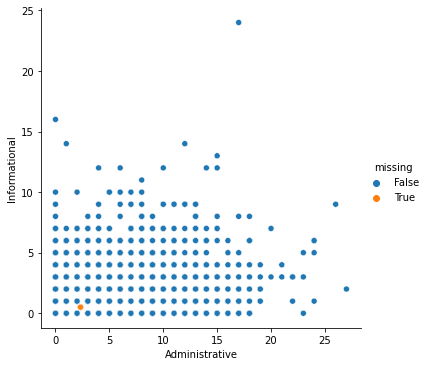

In [16]:
data_clean['missing'] = data[['Administrative','Informational']].isna().any(axis=1)
sns.relplot(x='Administrative', y='Informational', hue='missing', data=data_clean)

### KNN

In [17]:
data_clean = pd.DataFrame(KNNImputer().fit_transform(data), columns=data.columns)

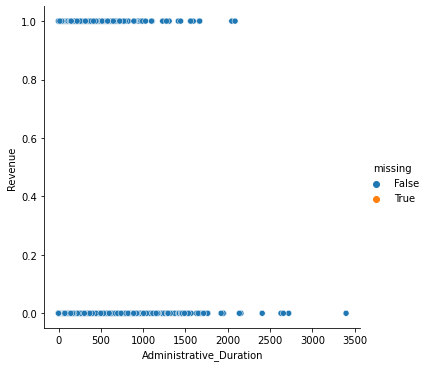

In [18]:
data_clean['missing'] = data[['Administrative_Duration','Informational']].isna().any(axis=1)
sns.relplot(x='Administrative_Duration', y='Revenue', hue='missing', data=data_clean)

In [19]:
data_clean

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,New_Visitor,Other,Returning_Visitor,missing
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.000000,0.0,...,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.000000,0.0,...,4.0,1.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.000000,0.0,...,3.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.000000,0.0,...,3.0,3.0,1.0,4.0,1.0,0.0,0.0,0.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3.0,145.0,0.0,0.0,53.0,1783.791667,0.007143,0.029031,12.241717,0.0,...,4.0,6.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,False
12326,0.0,0.0,0.0,0.0,5.0,465.750000,0.000000,0.021333,0.000000,0.0,...,3.0,2.0,1.0,8.0,1.0,0.0,0.0,0.0,1.0,False
12327,0.0,0.0,0.0,0.0,6.0,184.250000,0.083333,0.086667,0.000000,0.0,...,3.0,2.0,1.0,13.0,1.0,0.0,0.0,0.0,1.0,False
12328,4.0,75.0,0.0,0.0,15.0,346.000000,0.000000,0.021053,0.000000,0.0,...,2.0,2.0,3.0,11.0,0.0,0.0,0.0,0.0,1.0,False


## Outliers + feature selector

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split

In [21]:
y = data.Revenue

In [22]:
outlier_detector = LocalOutlierFactor(contamination=0.05)
imputer = KNNImputer()
scaler = StandardScaler()

preprocessor = make_column_transformer((make_pipeline(imputer, scaler), data.columns))

model = LogisticRegression()
pipe = make_pipeline(preprocessor, model)
pipe.fit(data, y).score(data,y)

1.0

In [23]:
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.feature_selection import RFE

In [24]:
def OutlierExtractor(X, y):
    pred = LocalOutlierFactor().fit_predict(X)
    return (X[pred==1,:], y[pred==1])

In [25]:
pipe = Pipeline( (
          ('imputer', KNNImputer())
         ,('outliers', FunctionSampler(func=OutlierExtractor, validate = False))
         ,('scaler', StandardScaler())
         ,('feature_selector', RFE(LogisticRegression(), n_features_to_select=3))
         ,('model', LogisticRegression()))
        )

In [26]:
pipe.fit(data, y).score(data, y)

1.0

In [27]:
X, y = data.drop(['Revenue'], axis=1), data['Revenue']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [29]:
pipe.fit(X_train, y_train).score(X_test, y_test)

0.8821303054879697

## Selecting the best model

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error

In [31]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [32]:
for clf in (log_clf, rnd_clf, svm_clf):
    pipe = Pipeline( (
          ('imputer', KNNImputer())
         ,('outliers', FunctionSampler(func=OutlierExtractor, validate = False))
         ,('scaler', StandardScaler())
         ,('feature_selector', RFE(LogisticRegression(), n_features_to_select=3))
         ,('model', clf))
        )
    print(clf.__class__.__name__, pipe.fit(X_train, y_train).score(X_test, y_test))

LogisticRegression 0.8821303054879697
RandomForestClassifier 0.8659097053257637
SVC 0.8891592322249257


In [33]:
pipe_SVC = Pipeline( (
          ('imputer', KNNImputer())
         ,('outliers', FunctionSampler(func=OutlierExtractor, validate = False))
         ,('scaler', StandardScaler())
         ,('feature_selector', RFE(LogisticRegression(), n_features_to_select=3))
         ,('model', SVC()))
        )

In [34]:
pipe_SVC.fit(X_train, y_train)
y_pred = pipe_SVC.predict(X_test)
print(accuracy_score(y_test, y_pred), '\n', confusion_matrix(y_pred, y_test), '\n', classification_report(y_pred, y_test))

0.8891592322249257 
 [[3004  290]
 [ 120  285]] 
               precision    recall  f1-score   support

       False       0.96      0.91      0.94      3294
        True       0.50      0.70      0.58       405

    accuracy                           0.89      3699
   macro avg       0.73      0.81      0.76      3699
weighted avg       0.91      0.89      0.90      3699



We get a high score but hte recall for the 'True' class is low. This is because the data is unbalanced. 

## Balancing the data

c:\users\júlia\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Revenue', ylabel='count'>

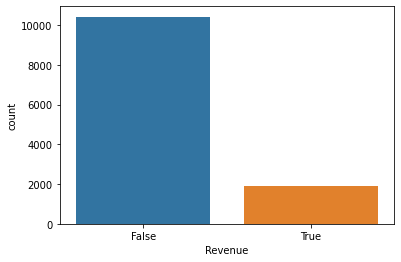

In [35]:
sns.countplot(data['Revenue'])

In [36]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

In [71]:
def Resampler(X, y):
    X_res, y_res = SMOTEENN().fit_resample(X, y)
    return X_res, y_res

In [72]:
pipe_res = Pipeline( (
          ('imputer', KNNImputer())
         #,('outliers', FunctionSampler(func=OutlierExtractor, validate = False))
         ,('scaler', StandardScaler())
         ,('resampler', FunctionSampler(func=Resampler, validate = False))
         #,('feature_selector', RFE(LogisticRegression(), n_features_to_select=3))
         ,('model', SVC()))
        )

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

In [74]:
pipe_res.fit(X_train, y_train)

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('resampler',
                 FunctionSampler(func=<function Resampler at 0x00000246C1E21670>,
                                 validate=False)),
                ('model', SVC())])

In [75]:
y_pred = pipe_res.predict(X_test)

In [76]:
print(classification_report(y, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [12330, 4932]

In [42]:
imputer = KNNImputer()

In [43]:
X_imp = imputer.fit_transform(X)

In [44]:
sc = StandardScaler()

In [45]:
X_std = sc.fit_transform(X_imp)

In [46]:
X_res, y_res = SMOTE().fit_resample(X_std, y)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.4, random_state=42)

In [48]:
y_pred = SVC().fit(X_train, y_train).predict(X_test)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.89      0.86      4173
        True       0.88      0.83      0.85      4165

    accuracy                           0.86      8338
   macro avg       0.86      0.86      0.86      8338
weighted avg       0.86      0.86      0.86      8338



c:\users\júlia\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Revenue', ylabel='count'>

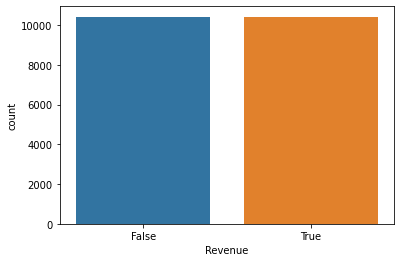

In [50]:
sns.countplot(y_res)

In [51]:
for resampler in (SMOTE(), BorderlineSMOTE(), SMOTETomek(), SMOTEENN()):
    X_res, y_res = resampler.fit_resample(X_std, y)
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.4, random_state=42)
    y_pred = SVC().fit(X_train, y_train).predict(X_test)
    print(resampler.__class__.__name__, accuracy_score(y_test, y_pred), classification_report(y_test, y_pred))

SMOTE 0.8602782441832574               precision    recall  f1-score   support

       False       0.84      0.89      0.86      4173
        True       0.88      0.83      0.86      4165

    accuracy                           0.86      8338
   macro avg       0.86      0.86      0.86      8338
weighted avg       0.86      0.86      0.86      8338

BorderlineSMOTE 0.8698728711921324               precision    recall  f1-score   support

       False       0.88      0.86      0.87      4173
        True       0.86      0.88      0.87      4165

    accuracy                           0.87      8338
   macro avg       0.87      0.87      0.87      8338
weighted avg       0.87      0.87      0.87      8338

SMOTETomek 0.8602861608753156               precision    recall  f1-score   support

       False       0.84      0.89      0.86      4112
        True       0.88      0.83      0.86      4205

    accuracy                           0.86      8317
   macro avg       0.86      0.86     

The best resampler is SMOTEENN.

c:\users\júlia\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Revenue', ylabel='count'>

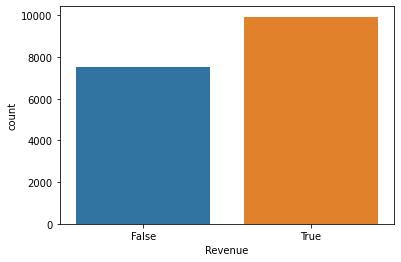

In [52]:
sns.countplot(y_res)

In [53]:
def ResamplerENN(X, y):
    X_res, y_res = SMOTEENN().fit_resample(X, y)
    return X_res, y_res

In [54]:
pipe_res = Pipeline( (
          ('imputer', KNNImputer())
         #,('outliers', FunctionSampler(func=OutlierExtractor, validate = False))
         ,('scaler', StandardScaler())
         ,('resampler', FunctionSampler(func=ResamplerENN, validate = False))
         #,('feature_selector', RFE(LogisticRegression(), n_features_to_select=3))
         ,('model', SVC()))
        )

In [55]:
y_pred = pipe_res.fit(X, y).predict(X)

In [56]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.90      0.93     10422
        True       0.60      0.81      0.69      1908

    accuracy                           0.89     12330
   macro avg       0.78      0.86      0.81     12330
weighted avg       0.91      0.89      0.90     12330



# Cross validation

In [57]:
from sklearn.model_selection import cross_val_score, cross_validate

Cross-validation with the pipeline

In [58]:
a = cross_val_score(pipe_res, X, y)
a

array([0.92944039, 0.89943228, 0.84549878, 0.82076237, 0.80981346])

In [59]:
b = cross_val_score(pipe_res, X, y, scoring='recall')
b

array([0.63779528, 0.74015748, 0.68848168, 0.66492147, 0.68324607])

In [60]:
c = cross_val_score(pipe_res, X, y, scoring='f1')
c

array([0.73493976, 0.69015796, 0.58597285, 0.53195876, 0.51794374])

Cross-validation with the best model (SVM with SMOTEEN)

In [61]:
X_res, y_res = SMOTEENN().fit_resample(X_std, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.4, random_state=42)
svm = SVC()

In [62]:
d = cross_val_score(svm, X_res, y_res)
d

array([0.93117293, 0.93518784, 0.9371953 , 0.89589905, 0.82936622])

In [63]:
e = cross_val_score(svm, X_res, y_res, scoring='recall')
e

array([0.89084507, 0.91201609, 0.92357969, 0.94972348, 0.95776772])

In [64]:
f = cross_val_score(svm, X_res, y_res, scoring='f1')
f

array([0.93654151, 0.94135963, 0.94374518, 0.91234001, 0.86492622])

In [81]:
g = cross_val_score(LogisticRegression(), X_res, y_res)
g

array([0.905076  , 0.9162604 , 0.9119587 , 0.87897907, 0.74075136])

In [82]:
h = cross_val_score(RandomForestClassifier(), X_res, y_res)
h

array([0.93203327, 0.97505019, 0.97275595, 0.95468884, 0.94493834])

In [83]:
for i in [a,b,c,d,e,f,g,h]:
    print(np.mean(i))
# el mejor resultado lo devuelve el random forest

0.8609894566098945
0.6829203941130396
0.6121946150454256
0.9057642672784627
0.9267864097607263
0.9197825114292121
0.8706051046745052
0.9558933180384285


# Hyperparameter Tuning

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [85]:
rf = RandomForestClassifier()

In [87]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [89]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num =u 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [94]:
model.fit(X_res, y_res)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [96]:
model.best_score_

0.8777081710020734

In [97]:
model.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=400)

In [98]:
model.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

Evaluating Randomized Search: 

In [99]:
cross_val_score_base_model = np.mean(cross_val_score(rf, X_res, y_res))
cross_val_score_base_model

0.9566963005448809

In [100]:
best_random = model.best_estimator_

In [101]:
cross_val_score_random = np.mean(cross_val_score(best_random, X_res, y_res))
cross_val_score_random

0.9587037568110123

To use Grid Search, we make another grid based on the best values provided by random search

In [104]:
# best params randomized search:
# {'bootstrap': True,
# 'max_depth': 70,
# 'max_features': 'auto',
# 'min_samples_leaf': 4,
# 'min_samples_split': 10,
# 'n_estimators': 400}

param_grid = {
    'bootstrap': [False],
    'max_depth': [50, 60, 70, 80, 90],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [300, 400, 500]
}

In [105]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [106]:
grid_search.fit(X_res, y_res)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


c:\users\júlia\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.87690511 0.87667568 0.87788031
 0.87461065 0.87650356 0.87593009        nan        nan        nan
 0.87122653 0.87323416 0.87208693 0.87174273 0.87289006 0.87065295
        nan        nan        nan 0.86812907 0.86715401 0.86841596
 0.86789971 0.86721127 0.8678423         nan        nan        nan
 0.87610209 0.87793764 0.87627421 0.87478285 0.87581539 0.87805237
        nan        nan        nan 0.87048085 0.87093978 0.87248844
 0.87243106 0.87254586 0.872087          nan        nan        nan
 0.8668098  0.86870279 0.86698185 0.86778496 0.86744077 0.86898951
        nan        nan        nan 0.87724928 0.87679043 0.87713455
 0.87782303 0.87690516 0.8761021         nan        nan        nan
 0.87105446 0.87168545 0.87329151 0.87329152 0.87266053 0.87116913
        nan        nan  

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [50, 60, 70, 80, 90],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [300, 400, 500]},
             verbose=2)

In [107]:
grid_search.best_score_

0.8780523655822159

In [108]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt',
                       min_samples_split=3, n_estimators=500)

In [109]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 500}

In [110]:
best_grid = grid_search.best_estimator_

In [111]:
cross_val_score_grid = np.mean(cross_val_score(best_grid, X_res, y_res))
cross_val_score_grid

0.9594493834241469

In [112]:
import pickle

In [113]:
filename = 'best_grid.sav'

In [114]:
pickle.dump(best_grid, open(filename, 'wb'))

# Loading and evaluating the model

In [115]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [116]:
np.mean(cross_val_score(loaded_model, X_res, y_res))

0.9589331803842844

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.4, random_state=42)

In [118]:
loaded_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt',
                       min_samples_split=3, n_estimators=500)

In [120]:
y_pred = loaded_model.predict(X_test)

In [121]:
confusion_matrix(y_test, y_pred)

array([[2883,  110],
       [  89, 3892]], dtype=int64)

In [122]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.96      0.97      2993
        True       0.97      0.98      0.98      3981

    accuracy                           0.97      6974
   macro avg       0.97      0.97      0.97      6974
weighted avg       0.97      0.97      0.97      6974



# Creating a pipeline